In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pickle
import csv
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import gdown
import joblib

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import lightgbm as lgb

import eli5
from eli5.sklearn import PermutationImportance

import os
import glob

# 코드 셀 실행 후 경고를 무시
# import warnings
# warnings.filterwarnings(action='ignore')

### Load Table

In [2]:
# pickle에서 데이터프레임 다시 불러오기
with open('data.pickle', 'rb') as f:
    df = pickle.load(f)

In [3]:
train_path = '../../data/train.csv'
test_path  = '../../data/test.csv'
dt_train = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt_train['is_test'] = 0
dt_test['is_test'] = 1
dt = pd.concat([dt_train, dt_test])

In [4]:
extra_data_path = '../yoon/extra_data/'

In [5]:
print(extra_data_path)
os.getcwd()


../yoon/extra_data/


'/root/upstage-ml-regression-3/Sh'

In [6]:
df['large_std_동'] = df['동']
df.drop(['동'], axis=1, inplace=True)

In [7]:
dt['동'] = dt['시군구'].apply(lambda x:x.split()[2])

In [8]:
dt = dt.reset_index()

In [9]:
df['동'] = dt['동']

In [65]:
df[df['아파트명']=='PH129']

,번지,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d
224566,129,PH129,273.96,202111,10,2020,압구정로79길 88,929070.0,0,854851.724138,청담동,199738.445661,277167.682927,1150000.0,1,3224.23
224567,129,PH129,273.96,202204,16,2020,압구정로79길 88,1450000.0,0,854851.724138,청담동,230216.769107,249733.258065,1450000.0,2,2975.71
241238,129,PH129,273.96,202103,14,2020,압구정로79길 88,1150000.0,0,854851.724138,청담동,199738.445661,277167.682927,1150000.0,1,2395.90
241239,129,PH129,273.96,202107,6,2020,압구정로79길 88,1000000.0,0,854851.724138,청담동,199738.445661,277167.682927,1150000.0,1,3148.29


In [66]:
df = df.drop(index =[224566,224567,241238,241239])

df

,번지,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d
0,658-1,개포6차우성,79.97,201712,3,1987,언주로 3,124000.0,0,120960.000000,개포동,32126.755612,108070.249556,260000.0,30,2372.640000
1,658-1,개포6차우성,79.97,201712,4,1987,언주로 3,123500.0,0,120960.000000,개포동,32126.755612,108070.249556,260000.0,30,2382.560000
2,658-1,개포6차우성,54.98,201712,5,1987,언주로 3,91500.0,0,120960.000000,개포동,32126.755612,108070.249556,260000.0,30,2394.480000
3,658-1,개포6차우성,79.97,201801,4,1987,언주로 3,130000.0,0,120960.000000,개포동,43598.058342,142378.337531,260000.0,31,2388.350000
4,658-1,개포6차우성,79.97,201801,2,1987,언주로 3,117000.0,0,120960.000000,개포동,43598.058342,142378.337531,260000.0,31,2382.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,816,신내우디안1단지,84.65,202307,13,2014,신내역로1길 85,NaN,1,39021.326676,신내동,11341.218441,54184.649123,85000.0,9,2428.570000
1128090,816,신내우디안1단지,84.62,202307,12,2014,신내역로1길 85,NaN,1,39021.326676,신내동,11341.218441,54184.649123,85000.0,9,2425.080000
1128091,816,신내우디안1단지,101.65,202308,12,2014,신내역로1길 85,NaN,1,39021.326676,신내동,11341.218441,54184.649123,85000.0,9,2420.253333
1128092,816,신내우디안1단지,84.94,202309,18,2014,신내역로1길 85,NaN,1,39021.326676,신내동,11341.218441,54184.649123,85000.0,9,2415.426667


### 년도에따라 동, 구별 statistics 추가

<Axes: xlabel='target', ylabel='Density'>

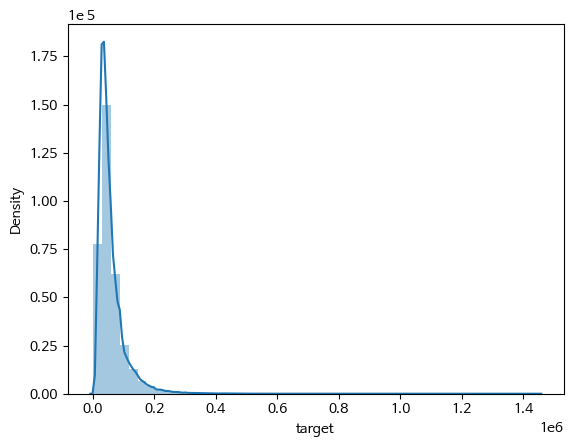

In [11]:
# df.drop(['아파트명'], axis=1, inplace=True)
sns.distplot(df.loc[:,'target'])

In [12]:
df

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,계약년,계약월,평균공시가격,계약일,date,large_std_동,동
0,658-1,658.0,개포6차우성,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,2017,12,120960.000000,8,2017-12-08,개포동,개포동
1,658-1,658.0,개포6차우성,79.97,201712,4,1987,언주로 3,123500.0,0,강남구,2017,12,120960.000000,22,2017-12-22,개포동,개포동
2,658-1,658.0,개포6차우성,54.98,201712,5,1987,언주로 3,91500.0,0,강남구,2017,12,120960.000000,28,2017-12-28,개포동,개포동
3,658-1,658.0,개포6차우성,79.97,201801,4,1987,언주로 3,130000.0,0,강남구,2018,01,120960.000000,3,2018-01-03,개포동,개포동
4,658-1,658.0,개포6차우성,79.97,201801,2,1987,언주로 3,117000.0,0,강남구,2018,01,120960.000000,8,2018-01-08,개포동,개포동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,816,816.0,신내우디안1단지,84.65,202307,13,2014,신내역로1길 85,NaN,1,중랑구,2023,07,39021.326676,19,2023-07-19,Unknown,신내동
1128090,816,816.0,신내우디안1단지,84.62,202307,12,2014,신내역로1길 85,NaN,1,중랑구,2023,07,39021.326676,25,2023-07-25,Unknown,신내동
1128091,816,816.0,신내우디안1단지,101.65,202308,12,2014,신내역로1길 85,NaN,1,중랑구,2023,08,39021.326676,27,2023-08-27,Unknown,신내동
1128092,816,816.0,신내우디안1단지,84.94,202309,18,2014,신내역로1길 85,NaN,1,중랑구,2023,09,39021.326676,2,2023-09-02,Unknown,신내동


In [13]:
#아파트명 csv로 보기.
# s_df = df[df.target>=270000]
# apt= s_df['아파트명'].value_counts()
# apt

# apt2 = pd.DataFrame({'아파트명': apt.index, 'num':apt.values})



# apt2.to_csv('apt2.csv', index=False)

<Axes: xlabel='target', ylabel='Density'>

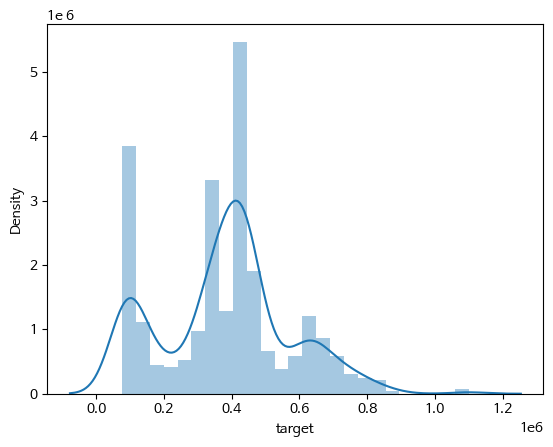

In [14]:
#문제의 한남 더 힐 분포 보기

hn = df[df['아파트명']=='한남더힐']

sns.distplot(hn.loc[:,'target'])



In [15]:
stats = df.groupby(['계약년', '구'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['계약년', '구'], rsuffix='_target')

In [16]:
df['계약년과구에따른std'] = df['std']
df['계약년과구에따른mean'] = df['mean']
df['계약년과구에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)
df.head(1)

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,...,계약년,계약월,평균공시가격,계약일,date,large_std_동,동,계약년과구에따른std,계약년과구에따른mean,계약년과구에따른max
0,658-1,658.0,개포6차우성,79.97,201712,3,1987,언주로 3,124000.0,0,...,2017,12,120960.0,8,2017-12-08,개포동,개포동,60408.755329,127433.7879,1053000.0


In [17]:
stats = df.groupby(['계약년', '동'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['계약년', '동'], rsuffix='_target')

In [18]:
df['계약년과동에따른std'] = df['std']
df['계약년과동에따른mean'] = df['mean']
df['계약년과동에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)
df.head(1)

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,...,계약일,date,large_std_동,동,계약년과구에따른std,계약년과구에따른mean,계약년과구에따른max,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max
0,658-1,658.0,개포6차우성,79.97,201712,3,1987,언주로 3,124000.0,0,...,8,2017-12-08,개포동,개포동,60408.755329,127433.7879,1053000.0,32126.755612,108070.249556,260000.0


In [19]:
# '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max'의 null 값을
# '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'의 값으로 채우기
df['계약년과동에따른std'] = df['계약년과동에따른std'].fillna(df['계약년과구에따른std'])
df['계약년과동에따른mean'] = df['계약년과동에따른mean'].fillna(df['계약년과구에따른mean'])
df['계약년과동에따른max'] = df['계약년과동에따른max'].fillna(df['계약년과구에따른max'])

In [20]:
df.drop(['구', 'large_std_동', 'date', '본번', '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'], axis=1, inplace=True)

In [21]:
df.columns

Index(['번지', '아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target',
       'is_test', '계약년', '계약월', '평균공시가격', '계약일', '동', '계약년과동에따른std',
       '계약년과동에따른mean', '계약년과동에따른max'],
      dtype='object')

In [22]:
df['건축년도'].dtype

dtype('int64')

In [23]:
df['계약년월'].dtype

dtype('int64')

In [24]:
df['yrs_diff'] = df['계약년월'].map(lambda x : x // 100) - df['건축년도']

In [25]:
df.columns

Index(['번지', '아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target',
       'is_test', '계약년', '계약월', '평균공시가격', '계약일', '동', '계약년과동에따른std',
       '계약년과동에따른mean', '계약년과동에따른max', 'yrs_diff'],
      dtype='object')

In [26]:
# Use glob to find all files that match the pattern
file_paths = glob.glob(extra_data_path + "/KOSPI_*.csv")


# Initialize an empty list to store the dataframes
dfs = []

# Iterate over the file paths and read each CSV file into a dataframe
for file_path in file_paths:
    kospi_df_yr = pd.read_csv(file_path, encoding="euc-kr")
    dfs.append(kospi_df_yr)

kospi_df = pd.concat(dfs, ignore_index=True)
kospi_df = kospi_df.drop(columns=['시가', '고가', '저가'])

In [27]:
kospi_df.rename(columns={"일자":"date", "종가":"Close"}, inplace=True)
kospi_df["date"] = kospi_df['date'].str.replace('/', '-')
kospi_df["date"] = pd.to_datetime(kospi_df["date"])
kospi_df.sort_values(by='date', ascending=True, inplace=True)

In [28]:
kospi_df["Close_delay120d"] = kospi_df["Close"].shift(120)

In [29]:
df.columns

Index(['번지', '아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target',
       'is_test', '계약년', '계약월', '평균공시가격', '계약일', '동', '계약년과동에따른std',
       '계약년과동에따른mean', '계약년과동에따른max', 'yrs_diff'],
      dtype='object')

In [30]:
df['date'] = pd.to_datetime(df['계약년'].astype(str) + '-' + df['계약월'].astype(str) + '-' + df['계약일'].astype(str))

In [31]:
df = pd.merge(left=df, right=kospi_df, on='date', how='left')

In [32]:
df.drop(columns=['date', 'Close', '대비', '등락률', '거래량', '거래대금', '상장시가총액'], inplace=True)

In [33]:
df["Close_delay120d"] = df["Close_delay120d"].interpolate(method='linear', axis=0)

In [34]:
df.columns

Index(['번지', '아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target',
       'is_test', '계약년', '계약월', '평균공시가격', '계약일', '동', '계약년과동에따른std',
       '계약년과동에따른mean', '계약년과동에따른max', 'yrs_diff', 'Close_delay120d'],
      dtype='object')

In [35]:
df.drop(columns=['계약년', '계약월', '계약일'], inplace=True)

In [36]:
df = df[df['계약년월']>=201501]
df.sort_values(by='계약년월')

,번지,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d
701077,336,장안현대홈타운,84.87,201501,14,2003,장안벚꽃로 107,43300.0,0,47463.663220,장안동,9339.081397,38387.940039,75900.0,12,2006.905000
720907,1500,금호삼성래미안,59.95,201501,12,2001,독서당로 343,40600.0,0,71502.749141,금호동1가,7498.316902,44702.148760,62000.0,14,2026.620000
720908,1500,금호삼성래미안,59.95,201501,8,2001,독서당로 343,40000.0,0,71502.749141,금호동1가,7498.316902,44702.148760,62000.0,14,2048.810000
668322,1158,우장산에스케이뷰,84.97,201501,8,2006,우현로 26,41000.0,0,48647.290640,화곡동,18485.524203,39325.281856,90198.0,9,2031.555000
668321,1158,우장산에스케이뷰,84.97,201501,4,2006,우현로 26,41300.0,0,48647.290640,화곡동,18485.524203,39325.281856,90198.0,9,2021.203333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121532,1002-1,럭키남서울,41.22,202309,7,1981,시흥대로47길 43,NaN,1,37601.724138,시흥동,18739.666871,54811.864407,102500.0,42,2395.690000
1121524,1013,관악산벽산타운5,59.34,202309,19,2004,금하로 816,NaN,1,34454.448399,시흥동,18739.666871,54811.864407,102500.0,19,2404.853333
1121523,1013,관악산벽산타운5,84.97,202309,19,2004,금하로 816,NaN,1,34454.448399,시흥동,18739.666871,54811.864407,102500.0,19,2392.026667
1125986,163-14,현대,59.91,202309,1,1997,오금로32길 42,NaN,1,64433.744856,송파동,27461.131123,135602.941176,210000.0,26,2405.486667


<Axes: xlabel='target', ylabel='Density'>

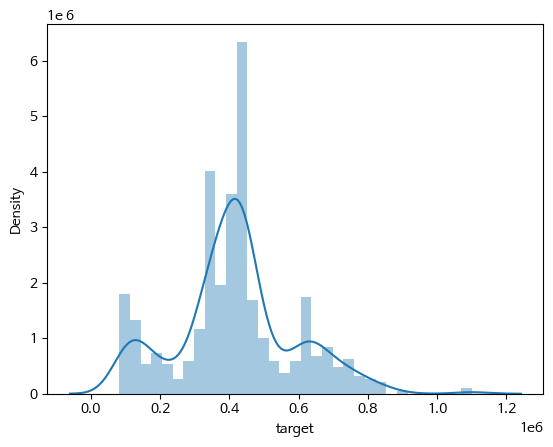

In [37]:
#문제의 한남더힐
hn=df[df['아파트명']=='한남더힐']
sns.distplot(hn.loc[:, 'target'])

In [38]:
df[df.target>=500000]['아파트명'].value_counts()

한남더힐           134
반포주공1단지         33
반포자이            27
래미안퍼스티지         26
아크로리버파크         24
              ... 
상지리츠빌장충동카일룸      1
디에이치아너힐즈         1
개포우성1            1
래미안라클래시          1
논현라폴리움           1
Name: 아파트명, Length: 63, dtype: int64

In [68]:
df[(df.target>=800000) & (df.target<1000000)]

,번지,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d
203590,128-18,상지리츠빌카일룸2차,244.3200,202303,5,2006,압구정로79길 87,821000.0,0,548860.000000,청담동,182535.447641,318581.395349,900000.0,17,2478.645
203591,128-18,상지리츠빌카일룸2차,244.3200,202305,16,2006,압구정로79길 87,900000.0,0,548860.000000,청담동,182535.447641,318581.395349,900000.0,17,2477.450
212646,18-1,래미안퍼스티지,222.7600,202211,22,2009,반포대로 275,840000.0,0,269199.631751,반포동,169468.123486,404819.448718,840000.0,13,2670.650
212662,18-1,래미안퍼스티지,222.7600,202304,25,2009,반포대로 275,810000.0,0,269199.631751,반포동,135631.866397,298195.588235,810000.0,14,2219.710
221948,829,나인원한남,206.8953,202211,8,2019,한남대로 91,945000.0,0,641836.656891,한남동,354143.419439,416847.500000,1350000.0,3,2550.080
221949,829,나인원한남,206.8953,202306,6,2019,한남대로 91,900000.0,0,641836.656891,한남동,279436.203653,334323.529412,1100000.0,4,2225.670
223824,467,타워팰리스1,301.4700,202205,56,2002,언주로30길 56,870000.0,0,249403.872967,도곡동,147611.133785,269415.363636,870000.0,20,2997.210
224097,369-1,현대1차,196.2100,202201,9,1976,압구정로29길 71,800000.0,0,375159.791667,압구정동,118147.086900,450217.948718,800000.0,46,3254.420
224102,369-1,현대1차,196.2100,202207,6,1976,압구정로29길 71,800000.0,0,375159.791667,압구정동,118147.086900,450217.948718,800000.0,46,2926.720
230647,18-1,래미안퍼스티지,222.7600,202203,22,2009,반포대로 275,800000.0,0,269199.631751,반포동,169468.123486,404819.448718,840000.0,13,3060.270


In [101]:
df[(df.target>=500000) & (df.target<800000)]['도로명'].unique()

array(['언주로30길 56', '영동대로 640', '압구정로 201', '영동대로142길 19', '압구정로79길 87',
       '도산대로101길 38', '독서당로 111', '삼성로 150', '남부순환로373길 23', '언주로30길 57',
       '압구정로42길 78', '압구정로 151', '압구정로 313', '압구정로29길 71', '압구정로 309',
       '학동로97길 31', '압구정로79길 76', '압구정로62길 17-4', '학동로81길 28', '반포대로 275',
       '신반포로 270', '동광로39길 18', '신반포로 45', '신반포로 9', '명달로 97-14',
       '잠원로 221-31', '왕십리로 83-21', '이촌로 248', '선릉로 221', '동호로20나길 30',
       '삼성로 11', '선릉로 120', '선릉로 206', '삼성로51길 35', '언주로30길 26',
       '남부순환로377길 26', '삼성로 651', '영동대로128길 45', '삼성로 636', '영동대로114길 72',
       '영동대로142길 21', '선릉로190길 84', '압구정로71길 28', '양화로 45', '신반포로15길 19',
       '왕십리로 16', '서울숲2길 32-14', '여의나루로 121', '이촌로 310', '남부순환로378길 9',
       '압구정로11길 17', '압구정로 403', '서빙고로 67', '서빙고로 35', '한남대로 91',
       '남부순환로378길 11', '도산대로61길 19', '압구정로79길 72', '왕십리로 85', '학동로46길 32'],
      dtype=object)

In [73]:
df[df['아파트명']=='압구정하이츠파크']

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,is_test


In [100]:


dt_test[dt_test['아파트명'] =='나인원한남']

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,is_test


In [40]:
df[df['도로명']=='영동대로 640'].target.mean()

376448.05194805196

In [41]:
apt = dt_test['아파트명'].value_counts()

apt2 = pd.DataFrame({'아파트명': apt.index, 'num':apt.values})



apt2.to_csv('apt2.csv', index=False)

### Feature Engineering

### Train

In [42]:
# is_20000 = True

In [43]:
# if is_20000:
#     df['계약년월']= df['계약년월'] - 200000
#     is_20000 = False
# df

In [44]:
df_train = df.loc[df['is_test']==0, :]
df_test = df.loc[df['is_test']==1, :]

# df_train.drop(['is_test'], axis=1, inplace=True)
# df_test.drop(['is_test'], axis=1, inplace=True)
print(df_train.shape, df_test.shape)

(636736, 16) (9272, 16)


In [49]:
doro = df_train.groupby('도로명')['target'].mean()

doro2 = pd.DataFrame({'아파트명': doro.index, 'num':doro.values.round(2)})



doro2.to_csv('doro2.csv', index=False)



In [54]:
doro3=doro2[doro2.num>=200000]

<Axes: xlabel='num', ylabel='Density'>

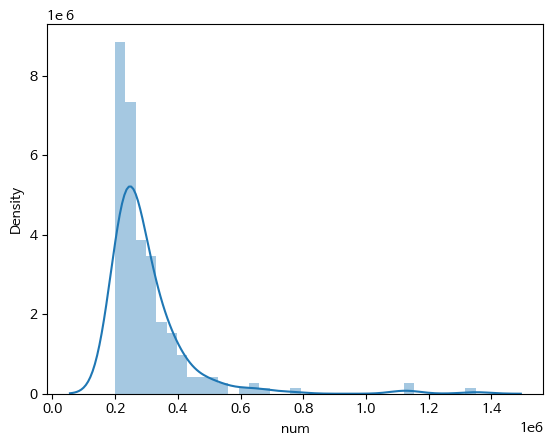

In [59]:
sns.distplot(doro3.loc[:,'num'])

In [61]:
doro3['아파트명'].unique()

df[df['도로명']=='개포로 264']

,번지,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d
201180,1282,개포래미안포레스트,84.83,202211,33,2020,개포로 264,240000.0,0,149270.905923,개포동,100307.493033,213071.212121,590000.0,2,2658.99
201181,1282,개포래미안포레스트,84.86,202211,5,2020,개포로 264,240000.0,0,149270.905923,개포동,100307.493033,213071.212121,590000.0,2,2626.34
201182,1282,개포래미안포레스트,59.92,202301,13,2020,개포로 264,158000.0,0,149270.905923,개포동,65335.877082,169735.593220,370000.0,3,2328.61
201183,1282,개포래미안포레스트,59.92,202301,13,2020,개포로 264,166000.0,0,149270.905923,개포동,65335.877082,169735.593220,370000.0,3,2381.94
201184,1282,개포래미안포레스트,59.92,202301,12,2020,개포로 264,167000.0,0,149270.905923,개포동,65335.877082,169735.593220,370000.0,3,2435.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118897,1282,개포래미안포레스트,84.86,202308,11,2020,개포로 264,NaN,1,149270.905923,개포동,65335.877082,169735.593220,370000.0,3,2432.07
1118898,1282,개포래미안포레스트,84.86,202308,15,2020,개포로 264,NaN,1,149270.905923,개포동,65335.877082,169735.593220,370000.0,3,2462.62
1118899,1282,개포래미안포레스트,74.66,202308,16,2020,개포로 264,NaN,1,149270.905923,개포동,65335.877082,169735.593220,370000.0,3,2419.09
1118900,1282,개포래미안포레스트,59.92,202309,13,2020,개포로 264,NaN,1,149270.905923,개포동,65335.877082,169735.593220,370000.0,3,2395.69


In [76]:
# 2015년 이후로 나누기.
# close_delay 제거
# 계약 년월 빼버리기.

df_train = df_train[df_train['계약년월']>=201501]
df_train = df_train.drop(columns='Close_delay120d')

# df_train = df_train.drop(columns='계약년월')
df_train


,번지,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff
0,658-1,개포6차우성,79.97,201712,3,1987,언주로 3,124000.0,120960.000000,개포동,32126.755612,108070.249556,260000.0,30
1,658-1,개포6차우성,79.97,201712,4,1987,언주로 3,123500.0,120960.000000,개포동,32126.755612,108070.249556,260000.0,30
2,658-1,개포6차우성,54.98,201712,5,1987,언주로 3,91500.0,120960.000000,개포동,32126.755612,108070.249556,260000.0,30
3,658-1,개포6차우성,79.97,201801,4,1987,언주로 3,130000.0,120960.000000,개포동,43598.058342,142378.337531,260000.0,31
4,658-1,개포6차우성,79.97,201801,2,1987,언주로 3,117000.0,120960.000000,개포동,43598.058342,142378.337531,260000.0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808035,2-1,종로센트레빌,84.92,201509,3,2008,동망산길 47,49500.0,59519.951923,숭인동,17493.711585,35101.183432,64800.0,7
808038,11-67,묵정,52.46,201502,7,1981,서애로1길 34,22700.0,27969.672131,묵정동,4392.920441,25575.000000,34000.0,34
808039,11-67,묵정,52.46,201506,5,1981,서애로1길 34,25900.0,27969.672131,묵정동,4392.920441,25575.000000,34000.0,34
808040,11-67,묵정,52.46,201506,6,1981,서애로1길 34,23500.0,27969.672131,묵정동,4392.920441,25575.000000,34000.0,34


In [86]:
# 변수 삭제 및 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in df_train.columns:
    if pd.api.types.is_numeric_dtype(df_train[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적(㎡)', '계약년월', '층', '건축년도', 'target', '평균공시가격', '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max', 'yrs_diff']
범주형 변수: ['번지', '도로명', '동']


In [87]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm(categorical_columns):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( df_train[col].astype(str) )
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


In [91]:

df_train0 = df_train[(df_train['전용면적(㎡)']<60)]
df_train60 = df_train[(df_train['전용면적(㎡)']>=60)&(df_train['전용면적(㎡)']<135)]
df_train135 = df_train[(df_train['전용면적(㎡)']>=135)]


In [116]:
df_train135.target.describe().round(2)

count      26900.00
mean      177070.93
std       110612.92
min        29000.00
25%       100000.00
50%       150000.00
75%       218500.00
max      1450000.00
Name: target, dtype: float64

In [94]:
df_train0.sort_values(by= '전용면적(㎡)', ascending=False)
df_train60.sort_values(by= '전용면적(㎡)', ascending=False)
df_train135.sort_values(by= '전용면적(㎡)', ascending=False)

,번지,전용면적(㎡),계약년월,층,건축년도,도로명,target,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff
211098,2692,59.9992,202304,10,2013,2836,111000.0,95851.176471,82,27782.416170,128608.695652,197000.0,10
492225,2692,59.9992,201704,10,2013,2836,72000.0,95851.176471,82,17245.443707,80651.629630,125000.0,4
211099,2692,59.9992,202304,8,2013,2836,110000.0,95851.176471,82,27782.416170,128608.695652,197000.0,10
492203,2692,59.9992,201701,9,2013,2836,65000.0,95851.176471,82,17245.443707,80651.629630,125000.0,4
492204,2692,59.9992,201701,9,2013,2836,64200.0,95851.176471,82,17245.443707,80651.629630,125000.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
267630,1647,10.1560,202105,14,2021,4453,50240.0,13673.737374,141,42813.816670,104742.145669,195200.0,0
267597,1647,10.1560,202105,18,2021,4453,50240.0,13673.737374,141,42813.816670,104742.145669,195200.0,0
267598,1647,10.1560,202105,10,2021,4453,50240.0,13673.737374,141,42813.816670,104742.145669,195200.0,0
267602,1647,10.1560,202105,8,2021,4453,50240.0,13673.737374,141,42813.816670,104742.145669,195200.0,0


In [95]:
y_train0 = df_train0['target']
X_train0 = df_train0.drop(['target'], axis=1)


y_train60 = df_train60['target']
X_train60 = df_train60.drop(['target'], axis=1)

y_train135 = df_train135['target']
X_train135 = df_train135.drop(['target'], axis=1)


# Split the data into train and validation sets
X_train0, X_val0, y_train0, y_val0 = train_test_split(X_train0, y_train0, test_size=0.2, random_state=2023)
X_train60, X_val60, y_train60, y_val60 = train_test_split(X_train60, y_train60, test_size=0.2, random_state=2023)
X_train135, X_val135, y_train135, y_val135 = train_test_split(X_train135, y_train135, test_size=0.2, random_state=2023)

In [96]:
gbm0 = lgb.LGBMRegressor(n_estimators=5000, max_depth=50, num_leaves=600, min_child_samples=50,
                            feature_fraction=0.7,
                            bagging_fraction=0.9, verbosity=-1)



gbm60 = lgb.LGBMRegressor(n_estimators=5000, max_depth=50, num_leaves=600, min_child_samples=50,
                            feature_fraction=0.7,
                            bagging_fraction=0.9, verbosity=-1)

gbm135 = lgb.LGBMRegressor(n_estimators=5000, max_depth=50, num_leaves=600, min_child_samples=50,
                            feature_fraction=0.7,
                            bagging_fraction=0.9, verbosity=-1)



In [97]:
gbm0.fit(
        X_train0, y_train0, 
        eval_set=[(X_train0, y_train0), (X_val0, y_val0)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2684.02	training's l2: 7.20395e+06	valid_1's rmse: 3539.04	valid_1's l2: 1.25248e+07
[200]	training's rmse: 2276.48	training's l2: 5.18237e+06	valid_1's rmse: 3372.54	valid_1's l2: 1.1374e+07
[300]	training's rmse: 2064.05	training's l2: 4.26029e+06	valid_1's rmse: 3327.55	valid_1's l2: 1.10726e+07
[400]	training's rmse: 1918.14	training's l2: 3.67927e+06	valid_1's rmse: 3312.87	valid_1's l2: 1.09751e+07
[500]	training's rmse: 1802.75	training's l2: 3.2499e+06	valid_1's rmse: 3310.15	valid_1's l2: 1.09571e+07
Early stopping, best iteration is:
[467]	training's rmse: 1839.96	training's l2: 3.38544e+06	valid_1's rmse: 3308.9	valid_1's l2: 1.09488e+07


LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.7, max_depth=50,
              min_child_samples=50, n_estimators=5000, num_leaves=600,
              verbosity=-1)

In [98]:
gbm60.fit(
        X_train60, y_train60, 
        eval_set=[(X_train60, y_train60), (X_val60, y_val60)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 4730.16	training's l2: 2.23744e+07	valid_1's rmse: 5847.07	valid_1's l2: 3.41882e+07
[200]	training's rmse: 3990.8	training's l2: 1.59265e+07	valid_1's rmse: 5493.35	valid_1's l2: 3.01769e+07
[300]	training's rmse: 3627.93	training's l2: 1.31619e+07	valid_1's rmse: 5386.77	valid_1's l2: 2.90173e+07
[400]	training's rmse: 3363.06	training's l2: 1.13101e+07	valid_1's rmse: 5343.37	valid_1's l2: 2.85516e+07
[500]	training's rmse: 3154.43	training's l2: 9.95045e+06	valid_1's rmse: 5325.94	valid_1's l2: 2.83656e+07
[600]	training's rmse: 2999.61	training's l2: 8.99765e+06	valid_1's rmse: 5314.04	valid_1's l2: 2.82391e+07
Early stopping, best iteration is:
[601]	training's rmse: 2998.08	training's l2: 8.98851e+06	valid_1's rmse: 5313.93	valid_1's l2: 2.82379e+07


LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.7, max_depth=50,
              min_child_samples=50, n_estimators=5000, num_leaves=600,
              verbosity=-1)

In [99]:
gbm135.fit(
        X_train135, y_train135, 
        eval_set=[(X_train135, y_train135), (X_val135, y_val135)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 14745.6	training's l2: 2.17434e+08	valid_1's rmse: 20979.6	valid_1's l2: 4.40145e+08
[200]	training's rmse: 11714.8	training's l2: 1.37237e+08	valid_1's rmse: 20384.6	valid_1's l2: 4.15534e+08
Early stopping, best iteration is:
[248]	training's rmse: 10846.1	training's l2: 1.17637e+08	valid_1's rmse: 20277.4	valid_1's l2: 4.11171e+08


LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.7, max_depth=50,
              min_child_samples=50, n_estimators=5000, num_leaves=600,
              verbosity=-1)

In [100]:
X_test = df_test.drop(['target'], axis=1)
X_test = X_test.drop(columns='Close_delay120d')
# X_test = X_test.drop(columns='계약년월')

X_test

,번지,전용면적(㎡),계약년월,층,건축년도,도로명,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff
1118822,4682,79.9700,202307,5,1987,6025,120960.000000,8,65335.877082,169735.593220,370000.0,36
1118823,4657,108.2017,202308,10,2021,464,155775.000000,8,65335.877082,169735.593220,370000.0,2
1118824,4658,161.0000,202307,15,1984,462,182537.777778,8,65335.877082,169735.593220,370000.0,39
1118825,4658,133.4600,202308,14,1984,462,182537.777778,8,65335.877082,169735.593220,370000.0,39
1118826,4658,104.4300,202308,6,1984,462,182537.777778,8,65335.877082,169735.593220,370000.0,39
...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,5716,84.6500,202307,13,2014,5423,39021.326676,173,11341.218441,54184.649123,85000.0,9
1128090,5716,84.6200,202307,12,2014,5423,39021.326676,173,11341.218441,54184.649123,85000.0,9
1128091,5716,101.6500,202308,12,2014,5423,39021.326676,173,11341.218441,54184.649123,85000.0,9
1128092,5716,84.9400,202309,18,2014,5423,39021.326676,173,11341.218441,54184.649123,85000.0,9


In [102]:
X_test0 = X_test[(X_test['전용면적(㎡)']<60)]
X_test60 = X_test[(X_test['전용면적(㎡)']>=60)&(X_test['전용면적(㎡)']<135)]
X_test135 = X_test[(X_test['전용면적(㎡)']>=135)]

In [103]:
real_test_pred0 = gbm0.predict(X_test0)
real_test_pred60 = gbm60.predict(X_test60)
real_test_pred135 = gbm135.predict(X_test135)


In [104]:
X_test0['target'] = real_test_pred0
X_test60['target'] = real_test_pred60
X_test135['target'] = real_test_pred135


In [105]:
# concat

concat_test = pd.concat([X_test0, X_test60, X_test135], axis=0)
concat_test = concat_test.sort_index()
concat_test


,번지,전용면적(㎡),계약년월,층,건축년도,도로명,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,target
1118822,4682,79.9700,202307,5,1987,6025,120960.000000,8,65335.877082,169735.593220,370000.0,36,183424.997000
1118823,4657,108.2017,202308,10,2021,464,155775.000000,8,65335.877082,169735.593220,370000.0,2,264629.595687
1118824,4658,161.0000,202307,15,1984,462,182537.777778,8,65335.877082,169735.593220,370000.0,39,312759.021688
1118825,4658,133.4600,202308,14,1984,462,182537.777778,8,65335.877082,169735.593220,370000.0,39,253232.573703
1118826,4658,104.4300,202308,6,1984,462,182537.777778,8,65335.877082,169735.593220,370000.0,39,206241.088137
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,5716,84.6500,202307,13,2014,5423,39021.326676,173,11341.218441,54184.649123,85000.0,9,73159.718170
1128090,5716,84.6200,202307,12,2014,5423,39021.326676,173,11341.218441,54184.649123,85000.0,9,73085.667736
1128091,5716,101.6500,202308,12,2014,5423,39021.326676,173,11341.218441,54184.649123,85000.0,9,77836.063143
1128092,5716,84.9400,202309,18,2014,5423,39021.326676,173,11341.218441,54184.649123,85000.0,9,70876.957392


In [111]:

# X_test에서 target만 분리.

ttt = concat_test.loc[:,'target']
ttt = pd.DataFrame(ttt)

ttt= ttt.reset_index()

preds_df= ttt.drop(columns='index')
preds_df= ttt.drop(columns='index')

preds_df2 = pd.DataFrame(preds_df['target'].astype(int), columns=["target"])
preds_df2

preds_df2.to_csv('gu-dong-encoded_fire7.csv', index=False)



In [42]:
# real_test_pred = gbm.predict(X_test)
# preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
# preds_df.to_csv('gu-dong-encoded_6pm.csv', index=False)

In [107]:
preds_df2.target.describe().round(2)

count       9272.00
mean      107999.42
std        76310.55
min         7658.00
25%        63001.25
50%        88349.50
75%       127907.25
max      1081333.00
Name: target, dtype: float64

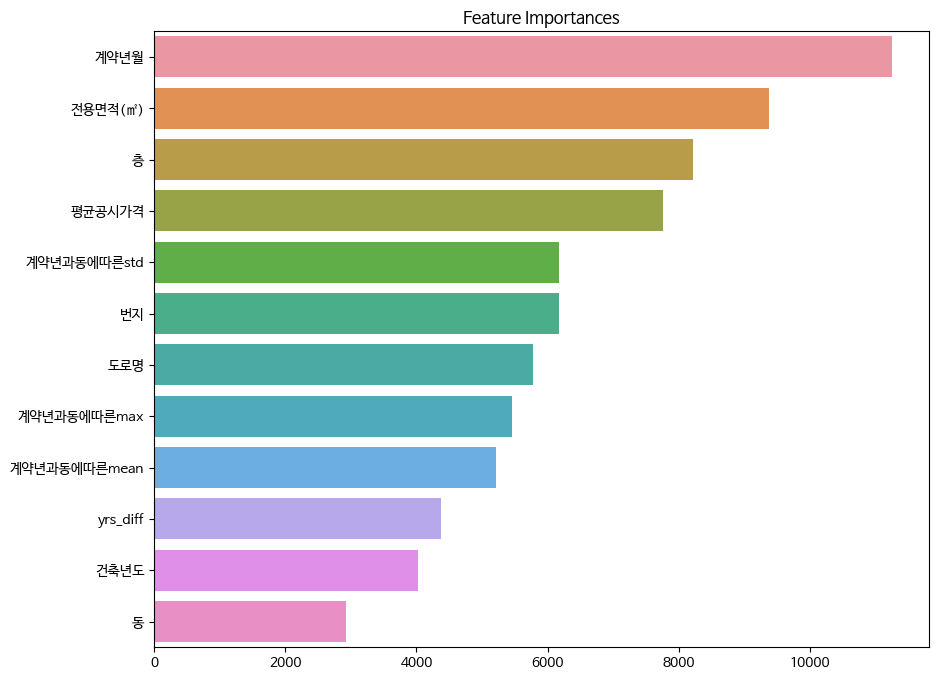

In [110]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(gbm135.feature_importances_, index=list(X_train135.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()